In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib as jl
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os

In [5]:
train_kalimati = pd.read_csv("../Datasets/Train_data/kalimati_tarkari_dataset_from_June_2013_to_May_2021.csv", index_col=False,)
train_imerge = pd.read_csv("../Datasets/Train_data/NASA-IMERG-Early 1 Day.csv", index_col=False)
train_sentinel = pd.read_csv("../Datasets/Train_data/Sentinel 1km - NSIDC SMAP.csv", index_col=False)
train_sport = pd.read_csv("../Datasets/Train_data/SPoRT Evaporative Stress Index (ESI-4WEEK).csv", index_col=False)
train_rainfall = pd.read_csv("../Datasets/Train_data/USCB CHIRPS Rainfall.csv", index_col=False)
train_smap = pd.read_csv("../Datasets/Train_data/USDA SMAP - moisture data.csv", index_col=False)

test_kalimati = pd.read_csv("../Datasets/Test_data/kalimati-tarkari-prices-from-may-2021-to-september-2023.csv", index_col=False)
test_imerge = pd.read_csv("../Datasets/Test_data/NASA IMERG Early 1 Day.csv", index_col=False)
test_sentinel = pd.read_csv("../Datasets/Test_data/Sentinel 1km - NSIDC SMAP.csv", index_col=False)
test_sport = pd.read_csv("../Datasets/Test_data/SPoRT Evaporative Stress Index (ESI-4week).csv", index_col=False)
test_rainfall = pd.read_csv("../Datasets/Test_data/UCSB CHIRPS Rainfall.csv", index_col=False)
test_smap = pd.read_csv("../Datasets/Test_data/USDA SMAP - moisture data.csv", index_col=False)

pd.set_option('display.max_rows', None)


train_kalimati.drop('SN', axis=1, inplace=True)


train_dataframes = [train_kalimati, train_imerge, train_sentinel, train_sport, train_rainfall, train_smap]
merged_train = train_dataframes[0]
for df in train_dataframes[1:]:
    merged_train = pd.merge(merged_train, df, on='Date', how='outer')

test_dataframes = [test_kalimati, test_imerge, test_sentinel, test_sport, test_rainfall, test_smap]
merged_test = test_dataframes[0]
for df in test_dataframes[1:]:
    merged_test = pd.merge(merged_test, df, on='Date', how='outer')

merged_test = merged_test.sort_values(by='Date')
merged_train = merged_train.sort_values(by='Date')


merged_train = merged_train.groupby('Date', group_keys=False).apply(lambda group: group.sort_values('Date'))

merged_train.interpolate(method='nearest', inplace=True)
merged_train.fillna(method='ffill', inplace=True)
merged_train.fillna(method='bfill', inplace=True)


merged_test = merged_test.groupby('Date', group_keys=False).apply(lambda group: group.sort_values('Date'))

merged_test.interpolate(method='nearest', inplace=True)
merged_test.fillna(method='ffill', inplace=True)
merged_test.fillna(method='bfill', inplace=True)

keywords = r'\b(India|Indian|\(India\)|China|Chinese|\(China\))\b'
merged_train = merged_train[~merged_train['Commodity'].str.contains(keywords, case=False, regex=True)]
merged_test = merged_test[~merged_test['Commodity'].str.contains(keywords, case=False, regex=True)]


#Use the code below to fill the value when Pandas is updated... It throws error in new version

# merged_train = merged_train.infer_objects()
# merged_train.update(merged_train.select_dtypes(include=['float64', 'int64']).interpolate(method='nearest'))

# merged_train.ffill(inplace=True)
# merged_test.ffill(inplace=True)

commodities_train_drop = ['Fish Fresh', 'Maize', 'Musk Melon']
commodities_test_drop = ['Amla', 'Avocado', 'Sarifa', 'Tree Tomato']

merged_train = merged_train.loc[~merged_train['Commodity'].isin(commodities_train_drop)]
merged_test = merged_test.loc[~merged_test['Commodity'].isin(commodities_test_drop)]

# Remove "Rs." and convert to numeric
merged_test['Average'] = merged_test['Average'].str.replace('Rs ', '', regex=False).astype(float)

train_data_encoded = pd.get_dummies(merged_train, columns=['Commodity'], prefix='Veg')
test_data_encoded = pd.get_dummies(merged_test, columns=['Commodity'], prefix='Veg')


C:\Users\user\AppData\Local\Temp\ipykernel_3904\4277122081.py:37: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_train.interpolate(method='nearest', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_3904\4277122081.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_train.fillna(method='ffill', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_3904\4277122081.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_train.fillna(method='bfill', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_3904\4277122081.py:44: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(cop

In [51]:
merged_train['Commodity'].value_counts()

Commodity
Brd Leaf Mustard         3267
Pumpkin                  3027
Lime                     2974
Okara                    2959
French Bean(Local)       2906
Bottle Gourd             2870
Mustard Leaf             2787
Cabbage(Local)           2780
Cauli Local              2754
Mushroom(Kanya)          2753
Ginger                   2751
Chilli Dry               2750
Tomato Small(Local)      2750
Raddish White(Local)     2748
Spinach Leaf             2747
Banana                   2747
Potato Red               2746
Coriander Green          2744
Bamboo Shoot             2744
Chilli Green             2739
Carrot(Local)            2739
Onion Green              2739
Brinjal Long             2737
Capsicum                 2727
Tamarind                 2717
Bitter Gourd             2712
Tofu                     2696
Cucumber(Local)          2687
Apple(Jholey)            2685
Garlic Green             2683
Water Melon(Green)       2679
Pomegranate              2643
Mint                     2643


In [49]:
merged_test['Commodity'].value_counts()

Commodity
Chilli Green(Machhe)     1243
Arum                     1088
Cabbage(Local)           1011
Bamboo Shoot              994
Fish Fresh(Bachuwa)       993
French Bean(Local)        993
Fish Fresh(Rahu)          993
Fish Fresh(Chhadi)        991
Ginger                    991
Coriander Green           991
Cauli Local               991
Chilli Dry                990
Fish Fresh(Mungari)       990
Banana                    990
Tofu                      990
Pomegranate               989
Brd Leaf Mustard          989
Lime                      989
Garlic Green              989
Bottle Gourd              989
Carrot(Local)             988
Onion Green               987
Sugarbeet                 986
Water Melon(Green)        986
Tamarind                  985
Potato Red                985
Chilli Green              984
Pumpkin                   984
Mushroom(Kanya)           983
Pineapple                 983
Bitter Gourd              983
Capsicum                  983
Mushroom(Button)          981


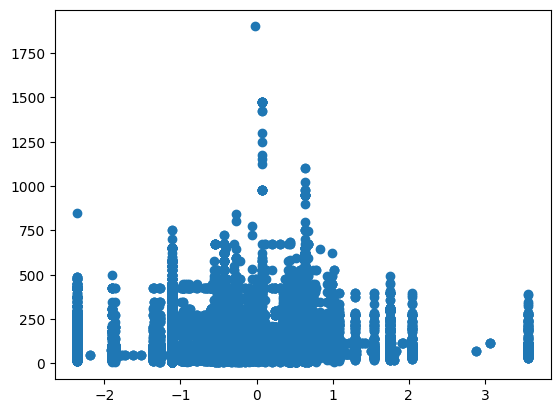

In [13]:
plt.scatter(merged_train['Surface soil moisture anomaly  - USDA SMAP: avg'], merged_train['Average'])


In [5]:

merged_train['imerge_avg'] = merged_train['NASA-IMERG-Early 1 Day: avg'].rolling(window=7, min_periods=1).mean()
merged_train['sentinel_avg'] = merged_train['NSIDC SMAP/Sentinel 1Km: avg'].rolling(window=7, min_periods=1).mean()
merged_train['sport_avg'] = merged_train['SPoRT Evaporative Stress Index (ESI-4WEEK): avg'].rolling(window=7, min_periods=1).mean()
merged_train['rainfall_avg'] = merged_train['UCSB CHIRPS Rainfall: avg'].rolling(window=7, min_periods=1).mean()
merged_train['smap1_avg'] = merged_train['Soil moisture profile - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_train['smap2_avg'] = merged_train['Sub surface soil moisture - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_train['smap3_avg'] = merged_train['Sub surface soil moisture anomaly - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_train['smap4_avg'] = merged_train['Surface soil moisture - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_train['smap5_avg'] = merged_train['Surface soil moisture anomaly  - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()

merged_test['imerge_avg'] = merged_test['NASA-IMERG-Early 1 Day: avg'].rolling(window=7, min_periods=1).mean()
merged_test['sentinel_avg'] = merged_test['NSIDC SMAP/Sentinel 1Km: avg'].rolling(window=7, min_periods=1).mean()
merged_test['sport_avg'] = merged_test['SPoRT Evaporative Stress Index (ESI-4WEEK): avg'].rolling(window=7, min_periods=1).mean()
merged_test['rainfall_avg'] = merged_test['UCSB CHIRPS Rainfall: avg'].rolling(window=7, min_periods=1).mean()
merged_test['smap1_avg'] = merged_test['Soil moisture profile - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_test['smap2_avg'] = merged_test['Sub surface soil moisture - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_test['smap3_avg'] = merged_test['Sub surface soil moisture anomaly - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_test['smap4_avg'] = merged_test['Surface soil moisture - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()
merged_test['smap5_avg'] = merged_test['Surface soil moisture anomaly  - USDA SMAP: avg'].rolling(window=7, min_periods=1).mean()



In [33]:
merged_train.tail()

,Commodity,Date,Unit,Minimum,Maximum,Average,NASA-IMERG-Early 1 Day: avg,NASA-IMERG-Early 1 Day: avg Percent of AOI with data,NSIDC SMAP/Sentinel 1Km: avg,NSIDC SMAP/Sentinel 1Km: avg Percent of AOI with data,...,Surface soil moisture anomaly - USDA SMAP: avg Percent of AOI with data,imerge_avg,sentinel_avg,sport_avg,rainfall_avg,smap1_avg,smap2_avg,smap3_avg,smap4_avg,smap5_avg
197835,Bottle Gourd,2021-5-5 00:00:00,Kg,15.0,20.0,17.5,8.810,100.0,0.283,0.00,...,100.0,18.987143,0.333143,-0.840286,18.263143,52.747143,49.062857,0.512857,16.775286,0.988429
197836,Bottle Gourd,2021-5-6 00:00:00,Kg,15.0,20.0,17.5,0.868,100.0,0.328,43.01,...,100.0,15.071429,0.325857,-0.800857,14.394429,46.434286,42.460429,0.256571,14.857000,0.716143
197837,Bottle Gourd,2021-5-7 00:00:00,Kg,15.0,20.0,17.5,12.290,100.0,0.301,27.90,...,100.0,6.288286,0.314714,-0.761429,4.979000,40.121429,35.858000,0.000286,12.938714,0.443857
197838,Bottle Gourd,2021-5-8 00:00:00,Kg,15.0,20.0,17.5,3.112,100.0,0.301,0.00,...,100.0,6.229714,0.303571,-0.722000,5.146714,33.808571,29.255571,-0.256000,11.020429,0.171571
197839,Bottle Gourd,2021-5-9 00:00:00,Kg,15.0,20.0,17.5,3.540,100.0,0.301,0.00,...,100.0,5.932286,0.306143,-0.727429,5.355714,34.708571,30.652286,-0.209571,10.827714,0.129143


In [6]:
train_combined = pd.concat([merged_train, train_data_encoded], axis=1)
test_combined = pd.concat([merged_test, test_data_encoded], axis=1)

In [54]:
train_combined.head()

,Commodity,Date,Unit,Minimum,Maximum,Average,NASA-IMERG-Early 1 Day: avg,NASA-IMERG-Early 1 Day: avg Percent of AOI with data,NSIDC SMAP/Sentinel 1Km: avg,NSIDC SMAP/Sentinel 1Km: avg Percent of AOI with data,...,Veg_Tofu,Veg_Tomato Big(Nepali),Veg_Tomato Small(Local),Veg_Tomato Small(Terai),Veg_Tomato Small(Tunnel),Veg_Turnip,Veg_Turnip A,Veg_Water Melon(Dotted),Veg_Water Melon(Green),Veg_Yam
0,Tomato Big(Nepali),2013-06-16,Kg,35.0,40.0,37.5,0.136,100.0,0.279,0.0,...,False,True,False,False,False,False,False,False,False,False
2,Potato Red,2013-06-16,Kg,20.0,21.0,20.5,0.136,100.0,0.279,0.0,...,False,False,False,False,False,False,False,False,False,False
3,Potato White,2013-06-16,Kg,15.0,16.0,15.5,0.136,100.0,0.279,0.0,...,False,False,False,False,False,False,False,False,False,False
5,Carrot(Local),2013-06-16,Kg,30.0,35.0,32.5,0.136,100.0,0.279,0.0,...,False,False,False,False,False,False,False,False,False,False
6,Cabbage(Local),2013-06-16,Kg,6.0,10.0,8.0,0.136,100.0,0.279,0.0,...,False,False,False,False,False,False,False,False,False,False


In [15]:
X_train = train_combined[
    ['imerge_avg', 'sentinel_avg', 'sport_avg', 'rainfall_avg', 'smap1_avg', 'smap2_avg', 'smap3_avg', 'smap4_avg', 'smap5_avg'] + 
    [col for col in train_combined.columns if col.startswith('Veg_')]
]

X_test = test_combined[
    ['imerge_avg', 'sentinel_avg', 'sport_avg', 'rainfall_avg', 'smap1_avg', 'smap2_avg', 'smap3_avg', 'smap4_avg', 'smap5_avg'] + 
    [col for col in test_combined.columns if col.startswith('Veg_')]
]


Y_train = train_combined['Average']
Y_train = Y_train.loc[:, ~Y_train.columns.duplicated(keep='first')]

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: (189643, 128)
Y_train shape: (189643, 1)


In [17]:
Y_train.shape

(189643, 1)

In [18]:
Y_train.tail()

,Average
197835,17.5
197836,17.5
197837,17.5
197838,17.5
197839,17.5


In [19]:
y_test = test_combined['Average']
y_test = y_test.loc[:, ~y_test.columns.duplicated(keep='first')]
y_test.head()

,Average
34289,45.0
34290,55.0
34292,65.0
34293,34.0
34295,23.5


In [20]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, Y_train)

y_pred = rf_model.predict(X_test)


y_pred_df = pd.DataFrame(y_pred, columns=['Predicted_Price'])


print(y_pred_df.head())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


   Predicted_Price
0        50.727787
1        65.487727
2        37.436844
3        59.713650
4        54.848407


In [21]:
mse_test = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (Test): {mse_test}")

Mean Squared Error (Test): 6238.871499308353


In [22]:
average_price = np.mean(y_test)
percentage_error = (np.sqrt(mse_test) / average_price) * 100

print(f"Percentage Error: {percentage_error:.2f}%")

Percentage Error: 62.81%
